In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
import sklearn.preprocessing as pre
import matplotlib.pyplot as plt
import seaborn as sns

import harness

In [2]:
flights_train = pd.read_csv('data/flights_train.csv', index_col=0)
flights_test = pd.read_csv('data/flights_test.csv', index_col=0)

In [3]:
flights_clean = harness.clean_train(flights_train)

In [11]:
outbound_traffic = flights_clean.origin.value_counts().to_frame(name='outbound_flights')

In [32]:
def add_outbound_traffic(df):
    return df.merge(
        outbound_traffic, left_on='origin', right_index=True, how='left'
    )

In [6]:
flights_with_outbound = add_outbound_traffic(flights_clean)

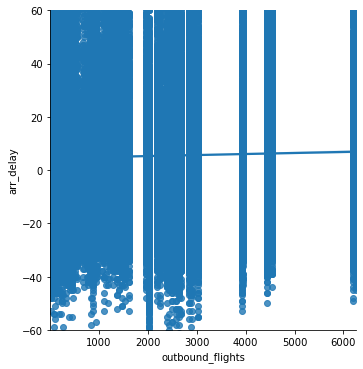

In [7]:
sns.lmplot(data=flights_with_outbound, x='outbound_flights', y='arr_delay')
plt.ylim(-60, 60)
plt.show()

In [10]:
inbound_traffic = flights_clean.dest.value_counts().to_frame(name='inbound_flights')

In [33]:
def add_inbound_traffic(df):
    return df.merge(
        inbound_traffic, left_on='dest', right_index=True, how='left'
    )

In [13]:
flights_with_inbound = add_inbound_traffic(flights_clean)

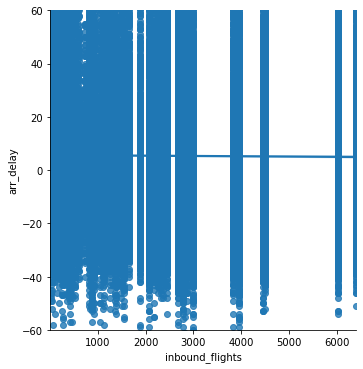

In [14]:
sns.lmplot(data=flights_with_inbound, x='inbound_flights', y='arr_delay')
plt.ylim(-60, 60)
plt.show()

In [34]:
def add_traffic(df):
    return add_inbound_traffic(add_outbound_traffic(df))[[
        'inbound_flights', 'outbound_flights'
    ]].fillna(0)

In [35]:
transformer = harness.DataTransformer(
    add_traffic, harness.normalize, harness.unnormalize
)

In [36]:
x_train, y_train = transformer.extract_transform(flights_clean)

In [44]:
def train_model():
    linreg = lm.LinearRegression()
    linreg.fit(x_train.values, y_train.values)
    harness.save(linreg, 'airport_size_model')

In [46]:
#train_model()

In [47]:
linreg = harness.load('airport_size_model')
linreg_model = harness.TrainedModel(linreg, transformer)

In [40]:
linreg_model.validate(harness.clean_train(flights_test))

-0.060151569970079644

In [42]:
linreg_model.submit(
    'data/test.csv', 'airport_size_submission.csv', 'predicted_delay'
)